In [1]:
import pandas as pd
import numpy as np
import json
from scipy.stats import pearsonr,spearmanr
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import gaussian_kde, linregress
from math import ceil, sqrt
from statsmodels.robust.robust_linear_model import RLM
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
import os
import datetime

In [3]:
#Load matching table
match_excel='Matching table.xlsx'
match_ID=pd.read_excel(match_excel,sheet_name='Sheet1',header=0)
match_ID

,实测站编号(FID_gauge),实测站河流编号(HYRIV_ID),实测站(Site_ID),虚拟站编号(FID_VS),虚拟站河流编号(HYRIV_ID),虚拟站节点地址(nodeID)
0,1,70433651,1036390,55540,70433651,73112001210385
1,3,70493612,1100693,51845,70493935,73118000030371
2,54,70492382,1354330,47649,70491056,73140400090371
3,54,70492382,1354330,47650,70491056,73140400100024
4,54,70492382,1354330,47651,70491056,73140400110061
...,...,...,...,...,...,...
490,3520,70801395,300507091355600,44276,70801395,74300400430115
491,3520,70801395,300507091355600,44277,70801395,74300400430215
492,3520,70801395,300507091355600,44278,70801395,74300400430315
493,3532,70753470,323045090484300,54391,70754512,74230800020231


In [4]:
# Import water level data from virtual stations (VS) and gauge stations
VS_file='../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2_na.json'
Gauge_file='USGS_gauge_stage_update_to_20240901.json'

with open(VS_file,'r') as f:
    VS_info=json.load(f)
with open(Gauge_file,'r') as g:
    gauge_info=json.load(g)

In [31]:
# Validate virtual stations against gauge measurements
# This code:
# 1. Matches virtual stations with corresponding gauge stations
# 2. Compares water level measurements and calculates validation metrics
# 3. Handles data filtering and quality control

# Extract gauge station IDs
gauge_FIDs=[item['FID'] for item in gauge_info]
gauge_FID_np=np.array(gauge_FIDs)
validate_items=[]
# Process each virtual station
for item_i,item in enumerate(VS_info):
    FID=item['FID_VS']
    nodeid=item['nodeid']
    VS_time=item['monitor_time']
    VS_wse=item['monitor_wse']
    VS_time_np=np.array(VS_time)
    VS_wse_np=np.array(VS_wse)
    VS_fluctuation=item['fluctuation2']
    VS_changerate=item['change_rate']*100

    VS_wse_stard=np.median(VS_wse_np)
    # Find matching gauge stations
    indices= match_ID.index[match_ID['matcded VS (nodeID)']==int(nodeid)].tolist()
    if (indices and len(indices) > 0) and (np.max(VS_wse_np)-np.min(VS_wse_np) <= 30):
        for gauge_index in indices:
            # Initialize validation arrays
            validate_VS_wse=[]
            validate_gauge_wse=[]
            validate_time=[]
            # Get gauge data
            gauge_ID=match_ID.loc[gauge_index,'gauge ID (FID_gauge)']
            selected_gauge=gauge_info[np.where(gauge_FID_np==gauge_ID)[0][0]]
            selected_gauge_time_excel=selected_gauge['Excel_date']
            selected_gauge_time_excel_np=np.array(selected_gauge_time_excel)
            selected_gauge_wse=selected_gauge['Water_level_m']
            selected_gauge_wse_np=np.array(selected_gauge_wse)
    
            for i,vs_date in enumerate(VS_time):
                vs_date_int=int(vs_date)
                date_index= (selected_gauge_time_excel_np>=vs_date_int) & (selected_gauge_time_excel_np<vs_date_int+1)
                if (sum(date_index)>0) & (abs(VS_wse_np[i]-VS_wse_stard)<(np.max(VS_wse_np)-np.min(VS_wse_np))*0.8):
                    validate_gauge_wse.append(np.median(selected_gauge_wse_np[date_index]))
                    validate_VS_wse.append(VS_wse_np[i])
                    validate_time.append(vs_date_int)
            # Calculate validation metrics if sufficient data pairs exist
            if len(validate_gauge_wse)>=10:
                # Calculate anomalies and statistics (RMSE, correlation, fluctuation)
               # Calculate change rates using robust regression
               # Store results in item dictionary
                validate_gauge_wse_anomaly=np.array(validate_gauge_wse)-np.mean(validate_gauge_wse)# transfer to anomaly
                validate_VS_wse_anomaly=np.array(validate_VS_wse)-np.mean(validate_VS_wse)
                validate_time_np=np.array(validate_time)

                rmse = np.sqrt(np.mean((validate_gauge_wse_anomaly - validate_VS_wse_anomaly) ** 2))

                CC, _ = spearmanr(validate_gauge_wse_anomaly, validate_VS_wse_anomaly)
                item['validate_VS_wse_anomaly']=validate_VS_wse_anomaly
                item['validate_gauge_wse_anomaly']=validate_gauge_wse_anomaly
                item['validate_RMSE']=rmse
                item['validate_CC']=CC
                item['validate_VS_fluctuation']=np.max(validate_VS_wse_anomaly)-np.min(validate_VS_wse_anomaly)
                item['validate_gauge_fluctuation']=np.max(validate_gauge_wse_anomaly)-np.min(validate_gauge_wse_anomaly)
    
                model_altimetric=RLM(validate_VS_wse_anomaly,sm.add_constant(validate_time_np),M=sm.robust.norms.TukeyBiweight())
                item['validate_VS_change_rate']=model_altimetric.fit().params[1] * 365*100 #cm/year
                model_gauge=RLM(validate_gauge_wse_anomaly,sm.add_constant(validate_time_np),M=sm.robust.norms.TukeyBiweight())
                item['validate_gauge_change_rate']=model_gauge.fit().params[1] * 365*100 #cm/year
    
                #print(rmse)
            else:
                # Initialize empty results if insufficient data
                item['validate_VS_wse_anomaly']=[]
                item['validate_gauge_wse_anomaly']=[]
                item['validate_RMSE']=[]
                item['validate_CC']=[]
                item['validate_VS_fluctuation']=[]
                item['validate_gauge_fluctuation']=[]
                item['validate_VS_change_rate']=[]
                item['validate_gauge_change_rate']=[]

            item2=item
            validate_items.append(item2)
                
    else:
        # Initialize empty results if no match found
        item['validate_VS_wse_anomaly']=[]
        item['validate_gauge_wse_anomaly']=[]
        item['validate_RMSE']=[]
        item['validate_CC']=[]
        item['validate_VS_fluctuation']=[]
        item['validate_gauge_fluctuation']=[]
        item['validate_VS_change_rate']=[]
        item['validate_gauge_change_rate']=[]

    if item_i % 500 == 0:
        print('Progress: {:.2f}%'.format(item_i/len(VS_info)*100))

Progress: 0.00%
Progress: 5.87%
Progress: 11.74%
Progress: 17.61%
Progress: 23.47%
Progress: 29.34%
Progress: 35.21%
Progress: 41.08%
Progress: 46.95%
Progress: 52.82%
Progress: 58.69%
Progress: 64.55%
Progress: 70.42%
Progress: 76.29%
Progress: 82.16%
Progress: 88.03%
Progress: 93.90%
Progress: 99.77%


In [32]:
# Extract virtual stations with valid validation metrics
validated_VS_info=[item for item in validate_items if item['validate_RMSE']]
len(validated_VS_info)

376

In [33]:
# Extract and analyze validation metrics for VS-gauge comparisons
# Collects multiple validation statistics:
# - RMSE and correlation coefficients
# - Water level fluctuations
# - Change rates
RMSEs=[item['validate_RMSE'] for item in validated_VS_info]
CCs=[item['validate_CC'] for item in validated_VS_info]
VS_fluctuation=[item['validate_VS_fluctuation'] for item in validated_VS_info]
gauge_fluctuation=[item['validate_gauge_fluctuation'] for item in validated_VS_info]
VS_changerate=[item['validate_VS_change_rate'] for item in validated_VS_info]
gauge_changerate=[item['validate_gauge_change_rate'] for item in validated_VS_info]

insitu_wse=[]
altimetric_wse=[]
insitu_fluctuation=[]
altimetric_fluctuation=[]

for item in validated_VS_info:
    insitu_wse.extend(item['validate_gauge_wse_anomaly'])
    altimetric_wse.extend(item['validate_VS_wse_anomaly'])
    insitu_fluctuation.append(item['validate_gauge_fluctuation'])
    altimetric_fluctuation.append(item['validate_VS_fluctuation'])

print(f'Median RMSE: {np.median(RMSEs):.2f} m; Mean RMSE: {np.mean(RMSEs):.2f} m.')
print(f'Median CC: {np.median(CCs):.2f}; Mean CC: {np.mean(CCs):.2f}.')
print(f'Median fluctuation: {np.median(VS_fluctuation):.2f} m; Median gauge fluctuation: {np.median(gauge_fluctuation):.2f} m.')
print(f'Median change rate: {np.median(VS_changerate):.2f} cm/yr; Median gauge change rate: {np.median(gauge_changerate):.2f} cm/yr.')


Median RMSE: 0.64 m; Mean RMSE: 0.89 m.
Median CC: 0.69; Mean CC: 0.58.
Median fluctuation: 3.37 m; Median gauge fluctuation: 2.92 m.
Median change rate: -2.95 cm/yr; Median gauge change rate: -3.27 cm/yr.


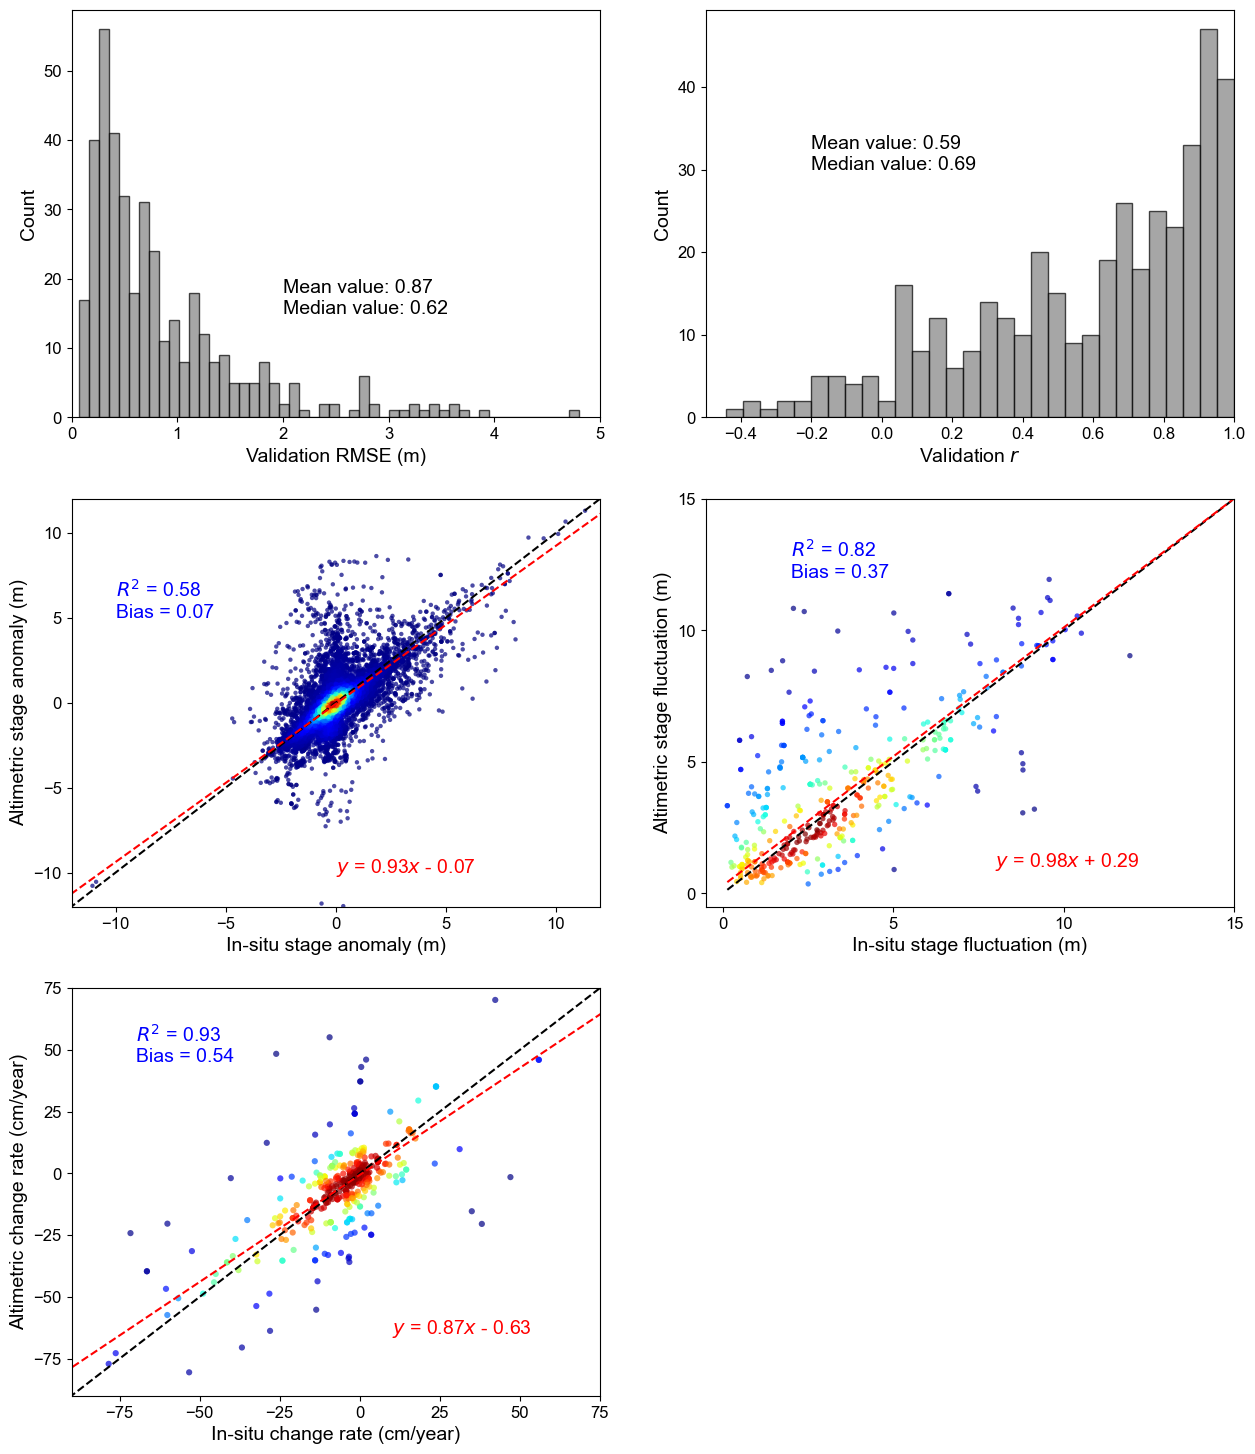

In [38]:
# Create comprehensive validation analysis figure with multiple panels
# - Distribution of validation metrics (RMSE, correlation)
# - Comparison of VS and gauge measurements
# - Analysis of water level fluctuations and change rates

def stats_cal(slope,intercept,gauge_changerate,VS_changerate):
    """Calculate statistical metrics for comparison"""
    predicted = slope * gauge_changerate + intercept
    residuals = VS_changerate - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((VS_changerate - np.mean(VS_changerate))**2)
    r2 = 1 - (ss_res / ss_tot)
    rmse = np.sqrt(np.mean(residuals**2))
    CC, _ = spearmanr(VS_changerate, gauge_changerate)
    bias=np.sum(residuals)/len(gauge_changerate)
    return r2,CC,bias

rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(15,18))#23.5,18

ax1 = fig.add_subplot(3, 2, 1)  # First subplot
ax2 = fig.add_subplot(3, 2, 2)  # Second subplot
ax3 = fig.add_subplot(3, 2, 3)  # Third subplot
ax4 = fig.add_subplot(3, 2, 4)  # Fourth subplot
ax6 = fig.add_subplot(3, 2, 5)
#ax0 = fig.add_subplot(3, 3, 6)
#ax7 = fig.add_subplot(3, 3, 7)
#ax8 = fig.add_subplot(3, 2, 6)
#ax9 = fig.add_subplot(3, 3, 9)

ax1.hist(RMSEs,bins=50,edgecolor='black',color='gray',alpha=0.7)
ax1.set_ylabel('Count', fontname='Arial',fontsize=14)
ax1.set_xlabel('Validation RMSE (m)', fontname='Arial',fontsize=14)
ax1.tick_params(labelsize=12)
mean_value=np.mean(RMSEs)
median_value=np.median(RMSEs)
ax1.text(2, 15, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='k', fontsize=14)
ax1.set_xlim([0,5])

ax2.hist(CCs,bins=30,edgecolor='black',color='gray',alpha=0.7)
ax2.set_ylabel('Count', fontname='Arial',fontsize=14)
ax2.set_xlabel('Validation $r$', fontname='Arial',fontsize=14)
ax2.tick_params(labelsize=12)
mean_value=np.mean(CCs)
median_value=np.median(CCs)
ax2.text(-0.2, 30, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='k', fontsize=14)
ax2.set_xlim([-0.5,1.0])

xy=np.vstack([insitu_wse,altimetric_wse])
z=gaussian_kde(xy)(xy)
scatter = ax3.scatter(insitu_wse, altimetric_wse, c=z, s=10, edgecolor='none', cmap='jet',alpha=0.7)
ax3.set_xlabel('In-situ stage anomaly (m)',fontsize=14)
ax3.set_ylabel('Altimetric stage anomaly (m)',fontsize=14)
ax3.tick_params(labelsize=12)
#slope, intercept, r_value, p_value, std_err = linregress(insitu_wse, altimetric_wse)
model=RLM(altimetric_wse,sm.add_constant(insitu_wse),M=sm.robust.norms.TukeyBiweight())
results=model.fit()
slope= results.params[1]
intercept= results.params[0]
p_value=results.pvalues[1]

ax3.plot([np.min(insitu_wse),np.max(insitu_wse)],[np.min(insitu_wse),np.max(insitu_wse)],color='k',linestyle='--',linewidth=1.5)
ax3.plot([np.min(insitu_wse),np.max(insitu_wse)],[np.min(insitu_wse)*slope+intercept,np.max(insitu_wse)*slope+intercept],'r--')
text = f'$y$ = {slope:.2f}$x$ - {abs(intercept):.2f}'
ax3.text(0, -10, text, fontsize=14, color='red',fontname='Arial')
ax3.set_xlim([-12,12])
ax3.set_ylim([-12,12])
r2,CC,bias=stats_cal(slope,intercept,np.array(insitu_wse),np.array(altimetric_wse))
stats_text = f'$R^2$ = {r2:.2f}\nBias = {bias:.2f}'#\nRMSE = {rmse:.0f}
ax3.text(-10, 5, stats_text, fontsize=14, color='blue', fontname='Arial')

xy=np.vstack([insitu_fluctuation,altimetric_fluctuation])
z=gaussian_kde(xy)(xy)
scatter = ax4.scatter(insitu_fluctuation, altimetric_fluctuation, c=z, s=15, edgecolor='none', cmap='jet',alpha=0.7)
ax4.set_xlabel('In-situ stage fluctuation (m)',fontsize=14)
ax4.set_ylabel('Altimetric stage fluctuation (m)',fontsize=14)
ax4.tick_params(labelsize=12)
#slope, intercept, r_value, p_value, std_err = linregress(insitu_wse, altimetric_wse)
model=RLM(altimetric_fluctuation,sm.add_constant(insitu_fluctuation),M=sm.robust.norms.TukeyBiweight())
results=model.fit()
slope= results.params[1]
intercept= results.params[0]
p_value=results.pvalues[1]

ax4.plot([np.min(insitu_fluctuation),np.max(insitu_fluctuation)],[np.min(insitu_fluctuation),np.max(insitu_fluctuation)],color='k',linestyle='--',linewidth=1.5)
ax4.plot([np.min(insitu_fluctuation),np.max(insitu_fluctuation)],[np.min(insitu_fluctuation)*slope+intercept,np.max(insitu_fluctuation)*slope+intercept],'r--')
text = f'$y$ = {slope:.2f}$x$ + {intercept:.2f}'
ax4.text(8, 1, text, fontsize=14, color='red',fontname='Arial')
ax4.set_xlim([-0.5,15])
ax4.set_ylim([-0.5,15])
ax4.yaxis.set_major_locator(MultipleLocator(5))
ax4.xaxis.set_major_locator(MultipleLocator(5))
r2,CC,bias=stats_cal(slope,intercept,np.array(insitu_fluctuation),np.array(altimetric_fluctuation))
stats_text = f'$R^2$ = {r2:.2f}\nBias = {bias:.2f}'#\nRMSE = {rmse:.0f}
ax4.text(2, 12, stats_text, fontsize=14, color='blue', fontname='Arial')

xy=np.vstack([gauge_changerate,VS_changerate])
z=gaussian_kde(xy)(xy)
scatter = ax6.scatter(gauge_changerate, VS_changerate, c=z, s=20, edgecolor='none', cmap='jet',alpha=0.7)
ax6.set_xlabel('In-situ change rate (cm/year)',fontsize=14)
ax6.set_ylabel('Altimetric change rate (cm/year)',fontsize=14)
ax6.tick_params(labelsize=12)
#slope, intercept, r_value, p_value, std_err = linregress(insitu_wse, altimetric_wse)
model=RLM(VS_changerate,sm.add_constant(gauge_changerate),M=sm.robust.norms.TukeyBiweight())
results=model.fit()
slope= results.params[1]
intercept= results.params[0]
p_value=results.pvalues[1]

ax6.plot([np.min(gauge_changerate),np.max(gauge_changerate)],[np.min(gauge_changerate),np.max(gauge_changerate)],color='k',linestyle='--',linewidth=1.5)
ax6.plot([np.min(gauge_changerate),np.max(gauge_changerate)],[np.min(gauge_changerate)*slope+intercept,np.max(gauge_changerate)*slope+intercept],'r--')
text = f'$y$ = {slope:.2f}$x$ - {abs(intercept):.2f}'
ax6.text(10, -65, text, fontsize=14, color='red',fontname='Arial')
ax6.set_xlim([-90,75])
ax6.set_ylim([-90,75])
ax6.yaxis.set_major_locator(MultipleLocator(25))
ax6.xaxis.set_major_locator(MultipleLocator(25))
r2,CC,bias=stats_cal(slope,intercept,np.array(gauge_changerate),np.array(VS_changerate))
stats_text = f'$R^2$ = {r2:.2f}\nBias = {bias:.2f}'#\nRMSE = {rmse:.0f}
ax6.text(-70, 45, stats_text, fontsize=14, color='blue', fontname='Arial')


plt.show()

In [39]:
#Save the figure in PDF format
ouput_name=r'validate_result.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

In [40]:
#Save the validated dataset to JSON file
def convert_to_native_type(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_native_type(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_type(element) for element in obj]
    else:
        return obj

filename_total = "../../Result datasets/Validation dataset/S3_Validated_water_level_dataset.json"

with open(filename_total, 'w') as f:
    json.dump(convert_to_native_type(validated_VS_info), f, indent=4)


print('Completely import!')

已全部导出
